## 一. 模型训练流程

In [39]:
##1. 导入数据
import pandas as pd
import numpy as np
from sklearn.metrics import roc_curve,  classification_report, auc , confusion_matrix, accuracy_score, f1_score, recall_score, precision_score,roc_auc_score
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, GridSearchCV, cross_val_score
import matplotlib.pyplot as plt
import os, pickle
import lightgbm as lgb
from xgboost import plot_importance, plot_tree
from tqdm import tqdm
import time


In [10]:
# 查看CPU核数
import multiprocessing
multiprocessing.cpu_count()

4

In [11]:
#设置禁止使用科学计数法
np.set_printoptions(suppress=True)
pd.options.display.float_format = '{: .9f}'.format
# dataframe展示全部列
import pandas as pd
pd.set_option("display.max_columns", 500)
pd.set_option("display.max_rows", 1000)

In [19]:
from tqdm import tqdm
def reader_pandas(file, chunkSize = 20000, patitions = 50):
    reader = pd.read_csv(file, header = 0, index_col=0, delimiter=',', iterator = True)  ## delimiter='\t'
    chunks = []
    with tqdm(range(patitions), 'Reading...') as t:
        for _ in t:
            try:
                chunk = reader.get_chunk(chunkSize)
                chunks.append(chunk)
            except StopIteration:
                break
    return pd.concat(chunks, ignore_index=False)

In [20]:
# 读取数据
filename = '../X_train_outlier.csv'
data = reader_pandas(filename)

Reading...:  70%|█████████████████████████████████████████████████                     | 35/50 [00:04<00:01,  8.41it/s]


In [21]:
# 查看数据形状和内存使用
data.shape, data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 707773 entries, 13599771 to 34973374
Data columns (total 21 columns):
sub_grade                           707773 non-null int64
revol_util                          707773 non-null float64
issue_d_year                        707773 non-null int64
annual_inc                          707773 non-null float64
tot_cur_bal                         707773 non-null float64
earliest_cr_line_year               707773 non-null float64
int_rate                            707773 non-null float64
revol_bal                           707773 non-null float64
tot_coll_amt                        707773 non-null float64
total_acc                           707773 non-null float64
term                                707773 non-null int64
collections_12_mths_ex_med          707773 non-null float64
loan_amnt                           707773 non-null float64
verification_status_Not Verified    707773 non-null int64
dti                                 707773 non-n

((707773, 21), None)

In [23]:
data.head()

,sub_grade,revol_util,issue_d_year,annual_inc,tot_cur_bal,earliest_cr_line_year,int_rate,revol_bal,tot_coll_amt,total_acc,term,collections_12_mths_ex_med,loan_amnt,verification_status_Not Verified,dti,pub_rec,total_rev_hi_lim,issue_d_month,total_rec_prncp,out_prncp,acc_now_delinq
member_id,,,,,,,,,,,,,,,,,,,,,
13599771,17,60.000000000,2014,55000.000000000,144784.000000000,1985.000000000,18.250000000,10020.000000000,0.000000000,31.000000000,0,0.000000000,8875.000000000,0,23.650000000,1.000000000,16700.000000000,3,3124.160000000,0.000000000,0
1491956,4,88.000000000,2012,43000.000000000,139458.189336000,1992.000000000,8.900000000,13202.000000000,225.702610320,18.000000000,0,0.000000000,12500.000000000,0,10.580000000,0.000000000,32068.620045500,5,12500.000000000,0.000000000,0
64687987,21,52.000000000,2015,101300.000000000,106215.000000000,2001.000000000,18.550000000,21467.000000000,770.000000000,27.000000000,1,0.000000000,33600.000000000,0,20.000000000,0.000000000,41300.000000000,9,1047.760000000,32552.240000000,0
8446850,5,28.900000000,2013,47840.000000000,129416.000000000,1988.000000000,9.710000000,6585.000000000,102.000000000,14.000000000,1,0.000000000,17000.000000000,0,4.010000000,0.000000000,22800.000000000,8,17000.000000000,0.000000000,0
58471388,17,40.500000000,2015,30000.000000000,15589.000000000,1999.000000000,16.990000000,4167.000000000,0.000000000,21.000000000,1,0.000000000,14000.000000000,0,31.850000000,0.000000000,10300.000000000,7,769.760000000,13230.240000000,0


In [25]:
data['acc_now_delinq'] = data['acc_now_delinq'].apply(lambda x: 1 if x>0 else 0)

In [26]:
data['acc_now_delinq'].value_counts()

0    704482
1      3291
Name: acc_now_delinq, dtype: int64

In [27]:
dataY = data.pop('acc_now_delinq')

In [28]:
dataX = data

In [29]:
cnt = len(dataX)
dataX.isnull().sum()/cnt

sub_grade                           0.000000000
revol_util                          0.000000000
issue_d_year                        0.000000000
annual_inc                          0.000000000
tot_cur_bal                         0.000000000
earliest_cr_line_year               0.000000000
int_rate                            0.000000000
revol_bal                           0.000000000
tot_coll_amt                        0.000000000
total_acc                           0.000000000
term                                0.000000000
collections_12_mths_ex_med          0.000000000
loan_amnt                           0.000000000
verification_status_Not Verified    0.000000000
dti                                 0.000000000
pub_rec                             0.000000000
total_rev_hi_lim                    0.000000000
issue_d_month                       0.000000000
total_rec_prncp                     0.000000000
out_prncp                           0.000000000
dtype: float64

In [32]:
# 定义函数: 根据饱和度来过滤因子
def filter_coverage( df, na_rate):
    cnt = len(df)
    df1 = df.isnull().sum()/cnt
    df2 = df1 < na_rate
    keep_colname = df2[df2==True].index
    return df[keep_colname]

In [33]:
# 根据有值率/饱和度 剔除小于一定饱和度的列
dataAfterFilter = filter_coverage(dataX, 0.2)

In [34]:
dataX.shape, dataAfterFilter.shape

((707773, 20), (707773, 20))

In [35]:
# 拼接x和y
Combine_Data = pd.concat([dataX, dataY], axis = 1)

## 2. 数据处理流程

In [40]:
# 复制一份数据，用来建模
readData = Combine_Data.copy()

In [ ]:
# # 1. 将时间特征按照距今天多久处理
# import time
# import datetime
# datetiemCols = ['first_active_date','second_active_date'] 
# for name in datetiemCols:
#     print(name)
#     readData[name] = (pd.datetime.now().date() - pd.to_datetime(readData[name]).dt.date ).dt.days

In [42]:
# 2. 获得object特征的列名
cate_cols = readData.select_dtypes(include='object').columns
print(list(cate_cols))

# 将object类型转成category类型
for c in cate_cols:
    readData[c] = readData[c].astype('category')

[]


In [46]:
readData.head()

,sub_grade,revol_util,issue_d_year,annual_inc,tot_cur_bal,earliest_cr_line_year,int_rate,revol_bal,tot_coll_amt,total_acc,term,collections_12_mths_ex_med,loan_amnt,verification_status_Not Verified,dti,pub_rec,total_rev_hi_lim,issue_d_month,total_rec_prncp,out_prncp,acc_now_delinq
member_id,,,,,,,,,,,,,,,,,,,,,
13599771,17,60.000000000,2014,55000.000000000,144784.000000000,1985.000000000,18.250000000,10020.000000000,0.000000000,31.000000000,0,0.000000000,8875.000000000,0,23.650000000,1.000000000,16700.000000000,3,3124.160000000,0.000000000,0
1491956,4,88.000000000,2012,43000.000000000,139458.189336000,1992.000000000,8.900000000,13202.000000000,225.702610320,18.000000000,0,0.000000000,12500.000000000,0,10.580000000,0.000000000,32068.620045500,5,12500.000000000,0.000000000,0
64687987,21,52.000000000,2015,101300.000000000,106215.000000000,2001.000000000,18.550000000,21467.000000000,770.000000000,27.000000000,1,0.000000000,33600.000000000,0,20.000000000,0.000000000,41300.000000000,9,1047.760000000,32552.240000000,0
8446850,5,28.900000000,2013,47840.000000000,129416.000000000,1988.000000000,9.710000000,6585.000000000,102.000000000,14.000000000,1,0.000000000,17000.000000000,0,4.010000000,0.000000000,22800.000000000,8,17000.000000000,0.000000000,0
58471388,17,40.500000000,2015,30000.000000000,15589.000000000,1999.000000000,16.990000000,4167.000000000,0.000000000,21.000000000,1,0.000000000,14000.000000000,0,31.850000000,0.000000000,10300.000000000,7,769.760000000,13230.240000000,0


In [48]:
# 删除掉一些不规范的不入模的因子
readData = readData.drop(['collections_12_mths_ex_med'], axis = 1)  # 引号里面写入列名

## 3.获得最终进入模型的数据, 开始训练，并验证结果

In [49]:
data_final_X = readData.iloc[:, :-1]
data_final_Y = readData.iloc[:, -1]

In [50]:
X_train, X_test, y_train, y_test = train_test_split(data_final_X, data_final_Y, test_size = 0.3,)

In [53]:
y_train.value_counts(),y_test.value_counts()

(0    493169
 1      2272
 Name: acc_now_delinq, dtype: int64, 0    211313
 1      1019
 Name: acc_now_delinq, dtype: int64)

In [54]:
gbm1 = lgb.LGBMClassifier(verbose_eval = True)
gbm1.fit(X_train, y_train, eval_metric='binary_error', categorical_feature = cate_cols,)

d:\ProgramData\Anaconda3\lib\site-packages\lightgbm\basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is []
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
        importance_type='split', learning_rate=0.1, max_depth=-1,
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0,
        verbose_eval=True)

#### 根据百分之一预测为1

In [ ]:
data_train = readData[readData['batch_no'].isin(['201907','201908'，'201909'，'201910'，'201911'])]
data_test = readData[readData['batch_no'].isin(['201912'])]
X_train = data_train.iloc[:, :-1]
y_train = data_train.iloc[:, -1]
X_test = data_test.iloc[:, :-1]
y_test = data_test.iloc[:,-1]
fromo sklearn.externals import joblib
modelpath = 'lgb6.pkl'
gbm1 = joblib.load(modelpath)

In [ ]:
y_predict = gbm1.predict_proba(X_test)
# 取概率前百分之一的作为1
a = np.percentile(y_predict[:,1],99)
print(a)
y_pred = [1 if value > a else 0 for value in y_predict[:, 1]]
y_predictions = y_pred
from collections import Counter
print('y_test', Counter(y_test), 'y_predictions', Counter(y_predictions))

#查看混淆矩阵召回率等评估指标
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_predictions, labels=[0,1])
acc = metrics.scorer.accuracy_score(y_test, y_predictions)
recall1 = metrics.scorer.recall_score(y_test, y_predictions, pos_label = 1)
precision1 = metrics.scorer.precision_score(y_test, y_predictions, pos_label = 1)
recall0 = metrics.scorer.recall_score(y_test, y_predictions, pos_label = 0)
precision0 = metrics.scorer.precision_score(y_test, y_predictions, pos_label = 0)

print("cm",cm)
print("acc",acc)
print("recall",recall1)
print("precision1",precision1)
print("recal0",recall0)
print("precision0",precision0)
print("auc", metrics.roc_auc_score(y_test, y_pred))

In [1]:
# 将全部预测按概率分成一百等分输出结果

# mean_prediction 预测均值
# result_all['recall'] 识别率
# result_all['precicion1'] 实际投诉率
# result_all['y_count'] 投诉量
# len(int(y_test/100)) 样本量

# 带for循环的模型效果评估
from sklearn import metrics
# 预测一下效果
y_predict = gbm1.predict_proba(X_test)
# for循环，看不同的分位点
result_all = []
prediction_tmp = sorted(y_predict[:, 1], reverse=True) 
i = 0
from collections import Counter
for m in range(100):
    b = np.percentile(y_predict[:,1], 99-m)
    y_predictions = [1 if value > b else 0 for value in y_predict[:,1]]
    # 精确率 实际投诉率
    # 召回率 累积识别率
    #查看混淆矩阵
    from sklearn import metrics
    cm = metrics.confusion_matrix(y_test, y_predictions, labels = [0,1])
    recall = metrics.scorer.recall_score(y_test, y_predictions, pos_label = 1)
    precision1 = metrics.scorer.precision_score(y_test, y_predictions, pos_label = 1)
    print(recall1)
    j = int(i+len(prediction_tmp)/100)
    tmp = {
        'mean_prediction': np.mean(prediction_tmp[i:j]),
        'cm' : str(cm),
        'precision1' : precision1,
        'recall1' : recall1
    }
    result_all.append(tmp)
    print(tmp)
    

NameError: name 'gbm1' is not defined

#### 按固定概率值预测

In [60]:
# 评估预测结果
from sklearn import metrics
# y_pred = gbm1.predict(X_test)
# y_predictions = [round(value) for value in y_pred]
y_predict = gbm1.predict_proba(X_test)
y_pred = [1 if value > 0.5 else 0 for value in y_predict[:,1]]
y_predictions = y_pred
pred_accuracy = accuracy_score(y_test, y_predictions)
print('acc:', metrics.accuracy_score(y_test, y_pred))
print('auc:', metrics.roc_auc_score(y_test, y_pred))
print('f1:',metrics.f1_score(y_test, y_predictions, average='micro'))

acc: 0.9938209973061055
auc: 0.5032132034398674
f1: 0.9938209973061055


In [58]:
pd.Series(y_test).value_counts(),pd.Series(y_predictions).value_counts()

(0    211313
 1      1019
 Name: acc_now_delinq, dtype: int64, 0    212023
 1       309
 dtype: int64)

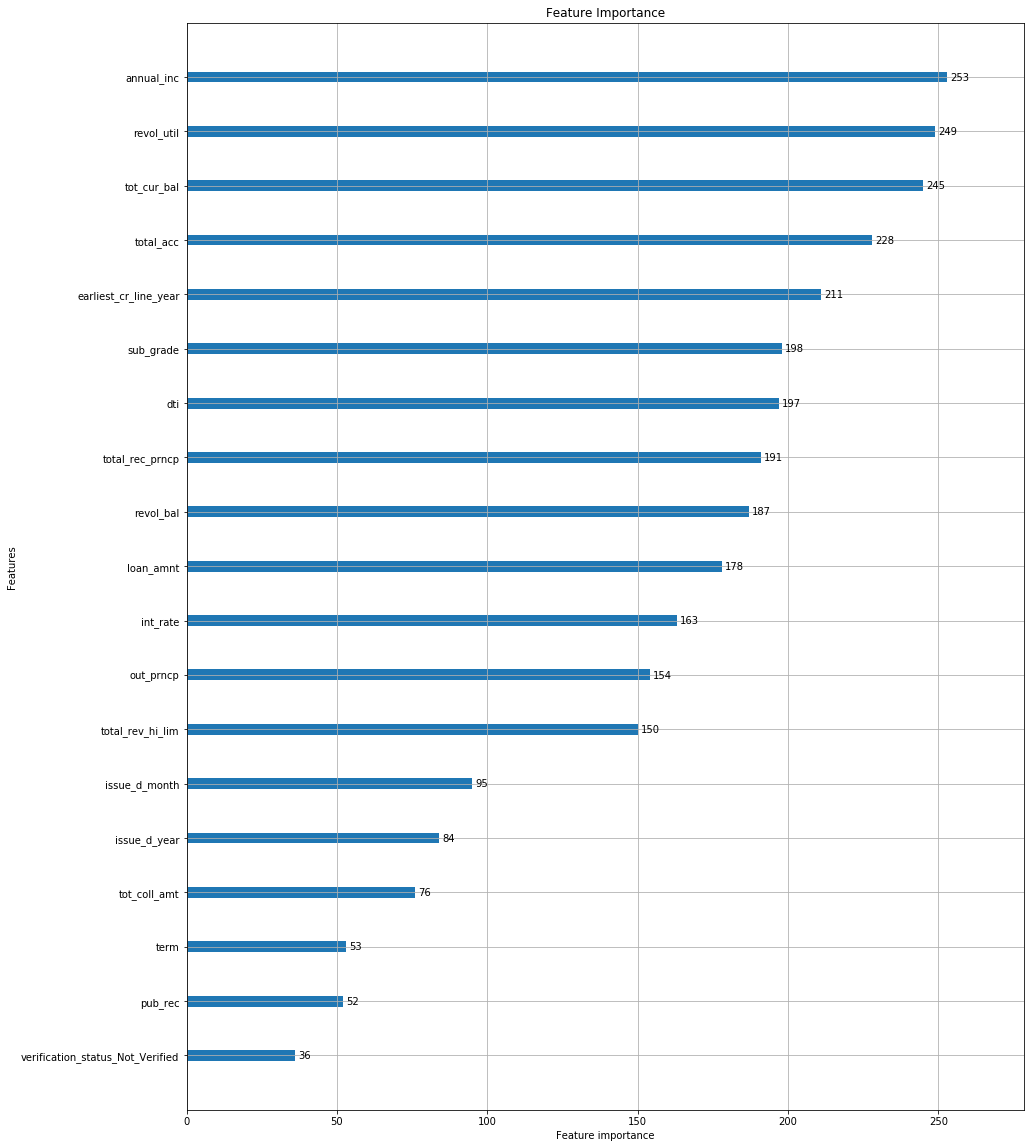

In [62]:
fig, ax = plt.subplots(figsize = (15, 20))
lgb.plot_importance(gbm1, max_num_features=90, ax = ax)
plt.title('Feature Importance')
plt.show()

In [63]:
# 查看混淆矩阵 召回率 精确率
from sklearn import metrics
cm = metrics.confusion_matrix(y_test, y_predictions, labels=[0,1])
acc = metrics.scorer.accuracy_score(y_test, y_predictions)
recall1 = metrics.scorer.recall_score(y_test, y_predictions, pos_label = 1)
precision1 = metrics.scorer.precision_score(y_test, y_predictions, pos_label = 1)
recall0 = metrics.scorer.recall_score(y_test, y_predictions, pos_label = 0)
precision0 = metrics.scorer.precision_score(y_test, y_predictions, pos_label = 0)

print("cm",cm)
print("acc",acc)
print("recall",recall1)
print("precision1",precision1)
print("recal0",recall0)
print("precision0",precision0)

cm [[211012    301]
 [  1011      8]]
acc 0.9938209973061055
recall 0.007850834151128557
precision1 0.025889967637540454
recal0 0.9985755727286064
precision0 0.9952316493965278


In [64]:
# https://blog.csdn.net/u011630575/article/details/80250177  混淆矩阵, recall precision auc roc 的解释

In [65]:
# 将使用到的因子名称保存到txt文件中
mylist = dataX.columns
with open('columnNames.txt', 'w') as f:
    f.write(','.join("'" + item + "'" for item in mylist))

In [66]:
## 4.将不同的模型保存成不同的PKL文件
from sklearn.externals import joblib
joblib.dump(gbm1, 'lgb6.pkl')

['lgb6.pkl']

## 附1.单因子分析

In [67]:
readData.head()

,sub_grade,revol_util,issue_d_year,annual_inc,tot_cur_bal,earliest_cr_line_year,int_rate,revol_bal,tot_coll_amt,total_acc,term,loan_amnt,verification_status_Not Verified,dti,pub_rec,total_rev_hi_lim,issue_d_month,total_rec_prncp,out_prncp,acc_now_delinq
member_id,,,,,,,,,,,,,,,,,,,,
13599771,17,60.000000000,2014,55000.000000000,144784.000000000,1985.000000000,18.250000000,10020.000000000,0.000000000,31.000000000,0,8875.000000000,0,23.650000000,1.000000000,16700.000000000,3,3124.160000000,0.000000000,0
1491956,4,88.000000000,2012,43000.000000000,139458.189336000,1992.000000000,8.900000000,13202.000000000,225.702610320,18.000000000,0,12500.000000000,0,10.580000000,0.000000000,32068.620045500,5,12500.000000000,0.000000000,0
64687987,21,52.000000000,2015,101300.000000000,106215.000000000,2001.000000000,18.550000000,21467.000000000,770.000000000,27.000000000,1,33600.000000000,0,20.000000000,0.000000000,41300.000000000,9,1047.760000000,32552.240000000,0
8446850,5,28.900000000,2013,47840.000000000,129416.000000000,1988.000000000,9.710000000,6585.000000000,102.000000000,14.000000000,1,17000.000000000,0,4.010000000,0.000000000,22800.000000000,8,17000.000000000,0.000000000,0
58471388,17,40.500000000,2015,30000.000000000,15589.000000000,1999.000000000,16.990000000,4167.000000000,0.000000000,21.000000000,1,14000.000000000,0,31.850000000,0.000000000,10300.000000000,7,769.760000000,13230.240000000,0


In [68]:
def autoSearch(data, cols, label = 'y', fea_map = {}):
    total = pd.DataFrame()
    ind = pd.Series()
    for fea in cols:
        data.loc[:,fea] = data.loc[:, fea].astype('str')
        ind = pd.DataFrame(pd.Series(data.loc[:,fea].value_counts(), name = '0'))
        ind = ind.join(data.groupby(fea)[label].mean())
        part1_idx = pd.Series()
        for j in range(ind.shape[0]):
            name = pd.Series('[' + str(j+1) + ']' + ind.index[j])
            part1_idx = part1_idx.append(name)
        ind.index = part1_idx
        ind['fea_name'] = fea
        total = total.append(ind)
        total['cn_name'] = total.fea_name.map(fea_map)
        total['categories'] = total.index
    return total
import pylab
pylab.rcParams['figure.figsize'] = (10.0, 6.0)

In [ ]:
singleData = readData.copy()
column1 = 'revol_util'

In [ ]:
singleData[column1].describe()

In [ ]:
singleData[column1].value_counts()

In [ ]:
column2 = 'tmp_' + column1
singleData[column1] = pd.to_numeric(singleData[column1], errors = 'ignore')
singleData[column2] = pd.cut(singleData[column1],
                [-99999,0,100,200,500,99999999999], labels = ['<0', '(0,100]','(100,200]','(200,500]','>500'])
result = 